# Sentiment Analysis of Valheim (Video Game) based on Twitter Dataset using Keras BiLSTM

In [1]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from guess_language import guess_language as guess
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import preprocessor as p
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Bidirectional, Activation, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
import keras.backend as K
from sklearn.model_selection import train_test_split

In [ ]:
#attrs = []
#limit = 0

#for i,tweet in enumerate(sntwitter.TwitterSearchScraper('Valheim since:2022-11-01 until:2022-12-16').get_items()):
#    if limit>4999:
#        break
#    if(str(guess(tweet.content)) == "en"):
#        attrs.append([tweet.user.username, tweet.date, tweet.likeCount, tweet.sourceLabel, tweet.content])
#        limit += 1
    
## Creating a dataframe to load the list
#df = pd.DataFrame(attrs, columns=["User", "Date Created", "Number of Likes", "Source of Tweet", "Tweet"])

In [ ]:
#df['Date Created'] = pd.to_datetime(df['Date Created']).dt.date

In [2]:
df = pd.read_csv('scrapped_tweet.csv')
df = df.iloc[:,1:]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User             5000 non-null   object
 1   Date Created     5000 non-null   object
 2   Number of Likes  5000 non-null   int64 
 3   Source of Tweet  5000 non-null   object
 4   Tweet            5000 non-null   object
dtypes: int64(1), object(4)
memory usage: 195.4+ KB


In [4]:
df.head()

,User,Date Created,Number of Likes,Source of Tweet,Tweet
0,ElPibeCombo,2022-12-15,0,Twitter Web App,"@BS_artsss Oh, this is so good, i love it! can..."
1,MrsTadertaut,2022-12-15,5,Twitter Web App,Hello lovelies!\n\nTonight we are jumping back...
2,Meganoip,2022-12-15,0,Twitter Web App,Storyline: Noi found Block fighting with giant...
3,TaesTeahouse,2022-12-15,2,Twitter Web App,Ayo I'm totally not biased or anything but yal...
4,John90192410,2022-12-15,1,Twitter for Android,The Queen Wants it all... \nDid Mistlands solo...


In [5]:
wordnet_lemmatizer = WordNetLemmatizer()

In [6]:
tweet = (df["Tweet"].values.tolist())

In [7]:
stop_words = nltk.corpus.stopwords.words('english')

In [8]:
clean_tweet = []
for i in range(0,len(tweet)):
    temp = p.clean(tweet[i]).casefold()
    temp = temp.translate(str.maketrans('', '', string.punctuation))
    filtered = []
    words_temp = word_tokenize(temp)
    for c in words_temp:
        if c not in stop_words:
            c = wordnet_lemmatizer.lemmatize(c)
            filtered.append(c)
    cleaned = " ".join(filtered)
    clean_tweet.append(cleaned)
    
clean_tweet = pd.DataFrame(clean_tweet, columns=["Tweet"])

In [9]:
sentiments = SentimentIntensityAnalyzer()
clean_tweet["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in clean_tweet["Tweet"]]
clean_tweet["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in clean_tweet["Tweet"]]
clean_tweet["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in clean_tweet["Tweet"]]
clean_tweet['Compound'] = [sentiments.polarity_scores(i)["compound"] for i in clean_tweet["Tweet"]]

clean_tweet.head()

,Tweet,Positive,Negative,Neutral,Compound
0,oh good love cant wait get home play valheim,0.613,0.000,0.387,0.8591
1,hello loveliestonight jumping back made copper...,0.000,0.000,1.000,0.0000
2,storyline noi found block fighting giant valhe...,0.000,0.216,0.784,-0.7717
3,ayo im totally biased anything yall go watch l...,0.162,0.162,0.676,0.0018
4,queen want mistlands solo cheating died time b...,0.176,0.433,0.391,-0.8360


In [13]:
score = clean_tweet["Compound"].values
sentiment = []
for i in score:
    if i >= 0.05 :
        sentiment.append(1)
    elif i <= -0.05 :
        sentiment.append(0)
    else:
        sentiment.append(0)
clean_tweet["Sentiment"] = sentiment

clean_tweet.head()

,Tweet,Positive,Negative,Neutral,Compound,Sentiment
0,oh good love cant wait get home play valheim,0.613,0.000,0.387,0.8591,1
1,hello loveliestonight jumping back made copper...,0.000,0.000,1.000,0.0000,0
2,storyline noi found block fighting giant valhe...,0.000,0.216,0.784,-0.7717,0
3,ayo im totally biased anything yall go watch l...,0.162,0.162,0.676,0.0018,0
4,queen want mistlands solo cheating died time b...,0.176,0.433,0.391,-0.8360,0


In [10]:
t = Tokenizer()
t.fit_on_texts(clean_tweet["Tweet"])

In [11]:
vocab_size = len(t.word_index) + 1
input_length = 25
encoded_reviews = t.texts_to_sequences(tweet)
padded_reviews = pad_sequences(encoded_reviews, padding='post', maxlen=100)

In [14]:
X = padded_reviews
y = clean_tweet["Sentiment"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=26)

In [16]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length = 100))
model.add(Bidirectional(LSTM(5, return_sequences=True)))
model.add(Bidirectional(LSTM(5)))
model.add(Activation('relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss=['binary_crossentropy'] , optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 10)           81710     
                                                                 
 bidirectional (Bidirectiona  (None, 100, 10)          640       
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 10)               640       
 nal)                                                            
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 83,001
Trainable params: 83,001
Non-traina

In [17]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=35,epochs=3)

Epoch 1/3
86/86 [==============================] - 12s 73ms/step - loss: 0.6876 - accuracy: 0.5337 - val_loss: 0.6722 - val_accuracy: 0.6605
Epoch 2/3
86/86 [==============================] - 5s 63ms/step - loss: 0.6120 - accuracy: 0.7170 - val_loss: 0.5803 - val_accuracy: 0.7150
Epoch 3/3
86/86 [==============================] - 5s 63ms/step - loss: 0.4559 - accuracy: 0.8437 - val_loss: 0.5139 - val_accuracy: 0.7845


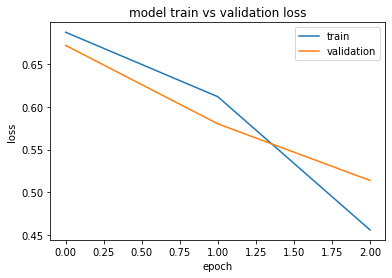

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()